# Demo Notebook on Reading and Exploring the Studentlife Dataset

In this example we download, preprocess and explore the [StudentLife Dataset](https://studentlife.cs.dartmouth.edu/dataset.html)<sup>[1]</sup>.


1.: Wang, Rui, Fanglin Chen, Zhenyu Chen, Tianxing Li, Gabriella Harari, Stefanie Tignor, Xia Zhou, Dror Ben-Zeev, and Andrew T. Campbell. "StudentLife: Assessing Mental Health, Academic Performance and Behavioral Trends of College Students using Smartphones." In Proceedings of the ACM Conference on Ubiquitous Computing. 2014.

In [1]:
import plotly.express as px
import plotly.io as pio
import warnings
from math import nan, inf
import pandas as pd
import niimpy
from niimpy.exploration.eda import countplot
from niimpy.preprocessing import survey
from niimpy.exploration.eda import categorical
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

# Plotly settings. Feel free to adjust to your needs.
pio.renderers.default = "png"
pio.templates.default = "seaborn"
px.defaults.template = "ggplot2"
px.defaults.color_continuous_scale = px.colors.sequential.RdBu
px.defaults.width = 1200
px.defaults.height = 482
warnings.filterwarnings("ignore")

api = KaggleApi()
api.authenticate()

api.dataset_download_files('dartweichen/student-life', path=".")
archive = zipfile.ZipFile('student-life.zip', 'r')

In [2]:
survey_file = archive.open(f"dataset/survey/PHQ-9.csv")
survey_data = pd.read_csv(survey_file)
survey_data = survey_data.rename(columns={'uid': 'user'})

In [3]:
PHQ9_MAP = {
    'Little interest or pleasure in doing things': "PHQ9_1",
    'Feeling down, depressed, hopeless.': "PHQ9_2",
    'Trouble falling or staying asleep, or sleeping too much.': "PHQ9_3",
    'Feeling tired or having little energy': "PHQ9_4",
    'Poor appetite or overeating': "PHQ9_5",
    'Feeling bad about yourself or that you are a failure or have let yourself or your family down': "PHQ9_6",
    'Trouble concentrating on things, such as reading the newspaper or watching television': "PHQ9_7",
    'Moving or speaking so slowly that other people could have noticed. Or the opposite being so figety or restless that you have been moving around a lot more than usual': "PHQ9_8",
    'Thoughts that you would be better off dead, or of hurting yourself': "PHQ9_9",
}
PHQ9_ANSWER_MAP = {
    "Not at all": 0,
    "Several days": 1,
    "More than half the days": 2,
    "Nearly every day": 3
}
selected_cols = [col for col in survey_data.columns if col in PHQ9_MAP.keys()]
transformed_df = pd.melt(survey_data, id_vars=['user', 'type'], value_vars=selected_cols, var_name='question', value_name='raw_answer')
transformed_df['id'] = transformed_df['question'].replace(PHQ9_MAP)
transformed_df['answer'] = survey.survey_convert_to_numerical_answer(
    transformed_df, answer_col = 'raw_answer', question_id = 'id',
    id_map={"PHQ9": PHQ9_ANSWER_MAP}, use_prefix=True
)
transformed_df = transformed_df.set_index("user")

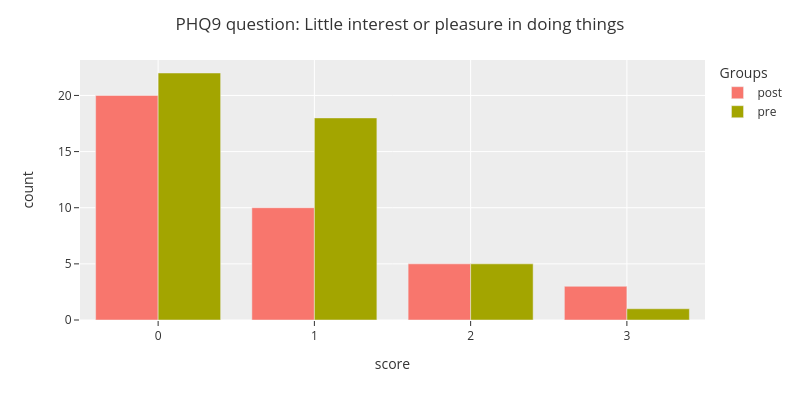

In [4]:
fig = categorical.questionnaire_grouped_summary(
    transformed_df, 
    question='PHQ9_1',
    group='type', 
    title='PHQ9 question: Little interest or pleasure in doing things',
    xlabel='score', 
    ylabel='count',
    width=800, 
    height=400
)
fig.show()

In [5]:
pre_study_survey = transformed_df[transformed_df["type"] == "pre"]
scores = survey.survey_sum_scores(pre_study_survey, "PHQ9")

In [6]:
def PHQ9_sum_to_group(sum):
    if sum < 5:
        return "minimal"
    elif sum < 10:
        return "mild"
    elif sum < 15:
        return "moderate"
    elif sum < 20:
        return "moderately severe"
    else:
        return "severe"
    
scores = scores.reset_index()
scores["group"] = scores["score"].apply(PHQ9_sum_to_group)

In [7]:
activity_data = []
for user_number in range(60):
    user = f"u{user_number:02}"
    try:
        csvfile = archive.open(f"dataset/sensing/activity/activity_{user}.csv")
        user_activity = pd.read_csv(csvfile)
        user_activity["user"] = user
        activity_data.append(user_activity)
    except:
        pass
activity_data = pd.concat(activity_data)

# Reduce activity data to whether the user was active or not. Values 1 and 2 represent activity.
activity_data = activity_data[activity_data[" activity inference"] != 3]
activity_data["activity"] = activity_data[" activity inference"].isin([1,2]).astype(int)


activity_data.set_index('timestamp',inplace=True)
activity_data.index = pd.to_datetime(activity_data.index, unit='s')

activity_data = niimpy.util.aggregate(activity_data, "1H")
activity_data = activity_data.reset_index("user")
activity_data = activity_data.replace([inf, -inf], nan).dropna(axis=0)
activity_data["activity"] = (activity_data["activity"]*5+0.5).round(0).astype(int)

In [8]:
activity_data = activity_data.reset_index().merge(
    scores[["user", "group"]],
    how="inner",
    on="user",
).set_index("timestamp")

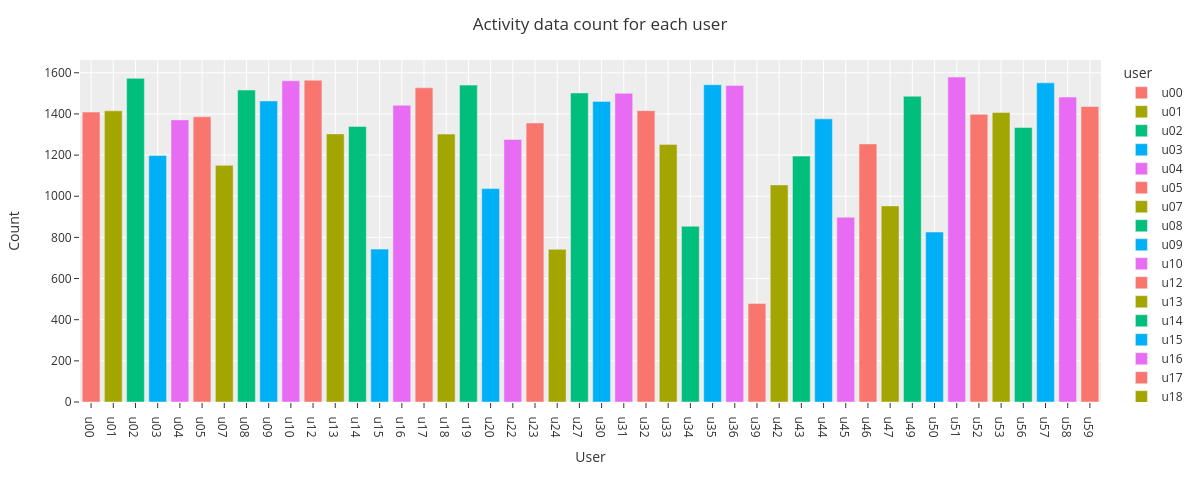

In [9]:
fig = countplot.countplot(activity_data,
                          fig_title='Activity data count for each user', 
                          plot_type='count', 
                          points='outliers',
                          aggregation='user', 
                          user=None,
                          column='activity',
                          binning=False)

fig.show()

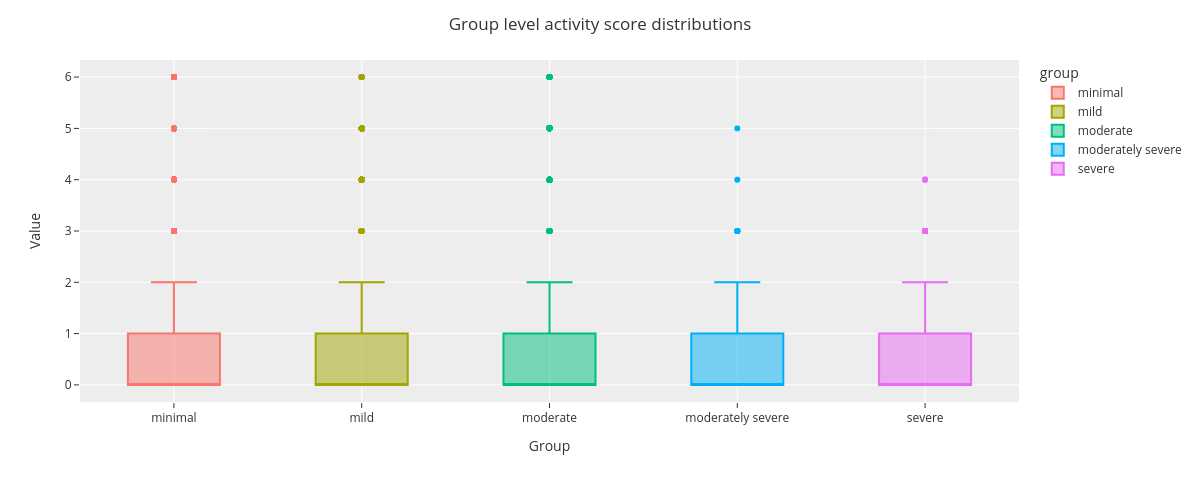

In [10]:
fig = countplot.countplot(activity_data, 
                          fig_title='Group level activity score distributions', 
                          plot_type='value', 
                          points='outliers',
                          aggregation='group', 
                          user=None,
                          column='activity',
                          binning=False)

fig.show()